**Author:** Andre Scholich <br>
**Last update:** 2019-01-18

# Basic example of waveform classification

In [99]:
import matplotlib.patches as mpatches
from pylab import plt, np
from scipy import ndimage as ndi
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.io import imread
from skimage.measure import label
from skimage.measure import regionprops
from skimage.morphology import closing, square
from skimage.segmentation import clear_border
from skimage.transform import downscale_local_mean
%matplotlib inline

Generate some example wave forms. Keep it simple for a start.

In [272]:
t = np.linspace(0, 10, 100)
n_samples = 50
sines = []
for _idx in range(n_samples):
    period = np.random.rand() + 0.5
    shift = 3 * np.random.rand()
    w1 = np.sin(t / period - shift)
    sines.append(w1)
rectangles = []
for _idx in range(n_samples):
    period = np.random.rand() + 0.5
    shift = 3 * np.random.rand()
    w2 = np.array([2*float(np.sin(_t / period - shift) > 0) - 1 for _t in t])
    rectangles.append(w2)
data = sines + rectangles
target = [0] * n_samples + [1] * n_samples

Show five examples each.

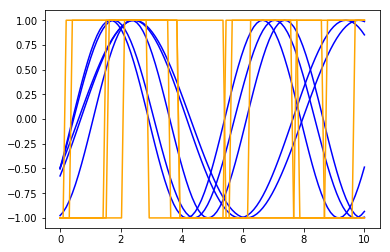

In [273]:
for k in range(5):
    plt.plot(t, sines[k], color='blue')
for k in range(5):
    plt.plot(t, rectangles[k], color='orange')

## Train SVM on annotated sample



In [274]:
from sklearn import datasets
from sklearn import svm

digits = datasets.load_digits()

clf = svm.SVC(gamma=0.001, C=100.)
clf.fit(data, target)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Generate a new waveform. First one should give 0 --> sine wave, second one should give 1 --> rectangular wave

In [275]:
period = np.random.rand() + 0.5
shift = 3 * np.random.rand()
w1 = np.sin(t / period - shift)
clf.predict(w1.reshape(1, -1))

array([0])

In [276]:
period = np.random.rand() + 0.5
shift = 3 * np.random.rand()
w2 = np.array([2*float(np.sin(_t / period - shift) > 0) - 1 for _t in t])
clf.predict(w2.reshape(1, -1))

array([1])

Construct proper test data. Here, I also allow for more variation in the periof and shift that was not part of the training data. This makes the task slightly more challenging. At this point, also noise and other factor can be added to get better insight into the robustness of the classifier.

Without the added variability (e.i. taking the same values of parameters in randomizing period and shift) a 50 sample training data already achieves a perfect score. With the added variability, 50 samples only achieve around 0.9

In [277]:
n_test = 50
test_sines = []
for _idx in range(n_test):
    period = 3 * np.random.rand() + 0.5
    shift = 6 * np.random.rand()
    w1 = np.sin(t / period - shift)
    test_sines.append(w1)
test_rectangles = []
for _idx in range(n_test):
    period = 3 * np.random.rand() + 0.5
    shift = 3 * np.random.rand()
    w2 = np.array([2*float(np.sin(_t / period - shift) > 0) - 1 for _t in t])
    test_rectangles.append(w2)
test_data = test_sines + test_rectangles
test_target = [0] * n_test + [1] * n_test

This values gives the mean accuracy of the predictor on the test data set. A bad predictor has accuracy of around 0.5 in our case (basically 50/50 chance) and a perfect predictor (on the test data) has a value of 1.

In [279]:
clf.score(test_data, test_target)

0.82

# Read from data files
Data files have been extracted to `sample_data/sine` and `sample_data/square`, respectively.
Each data file consists of one line of comma separated values.
Reading from individual files typically takes longer than it would to iterate through lines in one file.

In [280]:
n_sample = 100
sines = []
for k in range(n_sample):
    with open('sample_data/sine/sine_{}'.format(k)) as f:
        arr = np.array([float(item) for item in f.readline().split(',')])
        sines.append(arr)
squares = []
for k in range(n_sample):
    with open('sample_data/square/square_{}'.format(k)) as f:
        arr = np.array([float(item) for item in f.readline().split(',')])
        squares.append(arr)

In [285]:
len(sines[0])

62500

Look at the data.

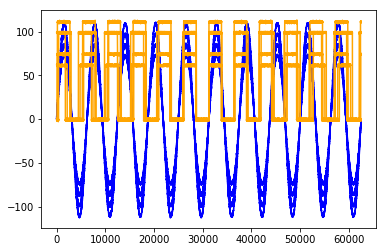

In [281]:
for k in range(5):
    plt.plot(range(len(sines[k])), sines[k], color='blue')
for k in range(5):
    plt.plot(range(len(squares[k])), squares[k], color='orange')

Construct a training and test set. Here, we take the first `n_training` samples of each group for training and the remaining for testing.

In [282]:
n_training = 80
training_data = sines[:n_training] + squares[:n_training]
training_target = [0] * n_training + [1] * n_training
test_data = sines[n_training:] + squares[n_training:]
test_target = [0] * (n_sample - n_training) + [1] * (n_sample - n_training)

In [283]:
clf2 = svm.SVC(gamma=0.001, C=100.)
clf2.fit(training_data, training_target)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

This values gives the mean accuracy of the predictor on the test data set. A bad predictor has accuracy of around 0.5 in our case (basically 50/50 chance) and a perfect predictor (on the test data) has a value of 1.
This the "out-of-sample" accuracy, meaning the accuracy of the classifier on data it has never seen before.

In [284]:
clf2.score(test_data, test_target)

0.6

In contrast to that, one can also look at the "in-sample" accuracy. Meaning the accuracy on the classifier on data it has already seen.

In [286]:
clf2.score(training_data, training_target)

1.0

In my testing I get an out-of-sample accuracy of 0.6 which is not great but at least slightly better than random. The in-sample accuracy is perfect.
There are two likely reasons for this, which influence each other.

The dimensionality of the feature space is very high and the number of samples (given this dimensionality) is very low.

The dimensionality of the features space in this case is the number of individual data points. In my example above, this number is 100 (the value in the np.linspace(0,10,100) command) whereas in the test data from the files this number is 62500. The important bit here is that the higher the dimensionality of the feature space, the more data one needs to train a good classifier. 
Higher dimensionality provides more "room" for different classes but also makes training harder. An indicator for a too-highly-dimensional feature space or a too-flexible classifier in general is a perfect in-sample accuracy but a bad out-of-sample accuracy. In essence, this means that the classifier just remembers the features of each individual sample instead of generalizing to a broader concept. 

This can be solved from two sides: making it harder for the classifier to learn individual samples (this can be adjusted by the parameters) and reducing the feature space (sub-sampling/averaging the input signal to 100 or so individual points) or throwing a lot of data with high variability on it to map out the vast feature space (typically unfeasible).

Let's try this. I am going to cheat a bit because I know how the data looks like. As there is no variability in the shift, we only need the first bit of the time signal to make a good prediction. So, I only take the first 100 data points of each signal.

In [294]:
n_training = 80
training_data = [s[:100] for s in sines[:n_training]] + [s[:100] for s in squares[:n_training]]
training_target = [0] * n_training + [1] * n_training
test_data = [s[:100] for s in sines[n_training:]] + [s[:100] for s in squares[n_training:]]
test_target = [0] * (n_sample - n_training) + [1] * (n_sample - n_training)

In [295]:
clf2 = svm.SVC(gamma=0.001, C=100.)
clf2.fit(training_data, training_target)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [296]:
clf2.score(test_data, test_target)

1.0

In principle, for the example of square waves vs sine waves, this should always work. Even, if there is variance in the shift, as long as this variance is also included in the training. The reason for this is that a sqare signal is constant for most of the times and a sine signal always changes from point to point. This characteristic can be seen from just a few datapoints. 